## Import Modules

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#import tensorflow_probability as tfp
from tensorflow.keras import layers, models

from IPython.display import clear_output
from tensorflow.keras.applications.vgg19 import VGG19
print(tf.__version__)

2.8.0


## Configs

In [2]:
########### YOUR CODE HERE ################
"""Tùy thuộc vào cách load data để cần 1 hay
nhiều path tới data ở đây mình dùng 2 nếu các 
bạn dùng ít hoặc nhiệu hơn thì có thể xóa hoặc 
khai báo thêm"""

# Path tới data folder 
PATH = '/media/aivn24/partition2/Khoa/AI2021/GAN/Project/data/data_prob1'
###########################################

BUFFER_SIZE = 20
BATCH_SIZE  = 1
IMG_WIDTH   = 1024
IMG_HEIGHT  = 256

LOW_WIDTH   = 256
LOW_HEIGHT  = 64

## Prepare Data

In [4]:
def load(image_path):
    ########### YOUR CODE HERE (OPTIONAL) ################

    """ ĐÂY LÀ ĐOẠN CODE OPTIONAL KHÔNG BẮT BUỘC PHẢI THỰC HIỆN 
    THEO FORMAT, NẾU CÓ CÁCH KHÁC CÁC BẠN CÓ THỂ CODE THEO Ý MÌNH 
    Thực hiện các bước load ảnh và xử lý ảnh cơ bản
    Parameters
    ----------
    image_path : string 
        Path dẫn đến file ảnh.
    
    Returns
    -------
    image_lr: tf.Tensor (tf.float32)
        ảnh input low resolution và nhiễu 
    target_lr: tf.Tensor (tf.float32)
        ảnh target low resolution không bị nhiễu 
    target_hr: tf.Tensor (tf.float32)
        ảnh target high resolution 
    """
    
    # read file và decode ảnh
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image)
    # resize image_lr, target_lr theo LOW_WIDTH và LOW_HEIGHT
    image_lr = tf.image.resize(image, size=(LOW_HEIGHT, LOW_WIDTH))
    target_lr = tf.image.resize(image, size=(LOW_HEIGHT, LOW_WIDTH))
    
    # resize target_hr  IMG_WIDTH và IMG_HEIGHT
    target_hr = tf.image.resize(image, size=(IMG_HEIGHT, IMG_WIDTH))
    
    # tạo ma trận noise có size theo LOW_WIDTH và LOW_HEIGHT
    noise_per = 0.20
    noise = tf.random.uniform(shape=(LOW_HEIGHT,LOW_WIDTH,3), minval=1-noise_per, maxval=1+noise_per)
    
    # Convert cả ảnh thành float32 tensors
    image_lr = tf.cast(image_lr, dtype=tf.float32)
    target_lr = tf.cast(target_lr, dtype=tf.float32)
    target_hr = tf.cast(target_hr, dtype=tf.float32)
    
    # image_lr nhân với ma trận noise để tạo ảnh nhiễu
    image_lr = image_lr*noise
    image_lr = tf.clip_by_value(image_lr, 0, 255)
    
    
    
    return image_lr, target_lr, target_hr
    ###########################################

(64, 256, 3)
(64, 256, 3)
(256, 1024, 3)


2022-03-30 22:14:05.122404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 22:14:05.134890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 22:14:05.136102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 22:14:05.137309: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

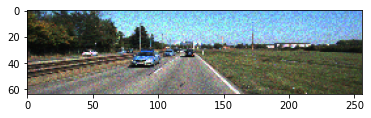

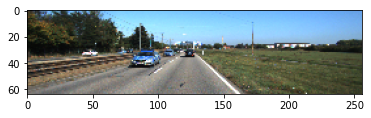

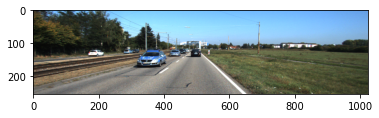

In [5]:
image_lr, target_lr, target_hr = load(PATH+'/train/000040_10.png')
print(image_lr.shape)
print(target_lr.shape)
print(target_hr.shape)


# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(image_lr/255.0)
plt.figure()
plt.imshow(target_lr/255.0)
plt.figure()
plt.imshow(target_hr/255.0)

In [6]:
def normalize(image_lr, target_lr, target_hr):
    ########### YOUR CODE HERE (OPTIONAL) ################
    """ ĐÂY LÀ ĐOẠN CODE OPTIONAL KHÔNG BẮT BUỘC PHẢI THỰC HIỆN 
    THEO FORMAT, NẾU CÓ CÁCH KHÁC CÁC BẠN CÓ THỂ CODE THEO Ý MÌNH 
    normalizing the images to [-1, 1]    
    Parameters
    ----------
    image_lr     : tf.Tensor (tf.float32) 
        ảnh input low resolution và nhiễu
    target_lr     : tf.Tensor (tf.float32) 
        ảnh target low resolution  
    target_hr    : tf.Tensor (tf.float32) 
        ảnh target high resolution 
    
    Returns
    -------
    image_lr     : tf.Tensor (tf.float32) 
        ảnh input low resolution và nhiễu
    target_lr     : tf.Tensor (tf.float32) 
        ảnh target low resolution  
    target_hr    : tf.Tensor (tf.float32) 
        ảnh target high resolution 
    """
    image_lr  = (image_lr/127.5) - 1  
    target_lr = (target_lr/127.5) - 1 
    target_hr = (target_hr/127.5) - 1 
    
    return image_lr, target_lr, target_hr
    ###########################################

#@tf.function()
def random_jitter(image_lr, target_lr, target_hr):
    ########### YOUR CODE HERE (OPTIONAL) ################
    """ ĐÂY LÀ ĐOẠN CODE OPTIONAL KHÔNG BẮT BUỘC PHẢI THỰC HIỆN 
    THEO FORMAT, NẾU CÓ CÁCH KHÁC CÁC BẠN CÓ THỂ CODE THEO Ý MÌNH 
    Có 50% cơ hội thực hiện flip ảnh từ trái sang phải 
    Parameters
    ----------
    image_lr     : tf.Tensor (tf.float32) 
        ảnh input low resolution và nhiễu
    target_lr     : tf.Tensor (tf.float32) 
        ảnh target low resolution  
    target_hr    : tf.Tensor (tf.float32) 
        ảnh target high resolution

    Returns
    -------
    image_lr     : tf.Tensor (tf.float32) 
        ảnh input low resolution và nhiễu
    target_lr     : tf.Tensor (tf.float32) 
        ảnh target low resolution  
    target_hr    : tf.Tensor (tf.float32) 
        ảnh target high resolution
    
    """
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        image_lr  = tf.image.flip_left_right(image_lr)
        target_lr  = tf.image.flip_left_right(target_lr)
        target_hr  = tf.image.flip_left_right(target_hr)
        
    return image_lr, target_lr, target_hr
    ###########################################
    

def load_image_train(image_path):
    ########### YOUR CODE HERE ################
    """ Thực hiện load image, random_jitter, và normalize ảnh 
    Parameters
    ----------
    image_path    : string
        path nơi chứa ảnh data

    Returns
    -------
    image_lr     : tf.Tensor (tf.float32) 
        ảnh input low resolution và nhiễu
    target_lr     : tf.Tensor (tf.float32) 
        ảnh target low resolution  
    target_hr    : tf.Tensor (tf.float32) 
        ảnh target high resolution
    """
    # load ảnh 
    image_lr, target_lr, target_hr = load(image_path)

    # random jiter 
    image_lr, target_lr, target_hr = random_jitter(image_lr, target_lr, target_hr)

    # normalize ảnh
    image_lr, target_lr, target_hr = normalize(image_lr, target_lr, target_hr)

    return image_lr, target_lr, target_hr
    ###########################################



def load_image_test(image_path):
    ########### YOUR CODE HERE ################
    """ Thực hiện load image, và normalize ảnh 
    Parameters
    ----------
    image_path    : string
        path nơi chứa ảnh data

    Returns
    -------
    image_lr     : tf.Tensor (tf.float32) 
        ảnh input low resolution và nhiễu
    target_lr     : tf.Tensor (tf.float32) 
        ảnh target low resolution  
    target_hr    : tf.Tensor (tf.float32) 
        ảnh target high resolution
    """
    # load ảnh 
    image_lr, target_lr, target_hr = load(image_path)

    # normalize ảnh
    image_lr, target_lr, target_hr = normalize(image_lr, target_lr, target_hr)


    return image_lr, target_lr, target_hr
    ###########################################


In [7]:
# train_dataset
########### YOUR CODE HERE ################
#thay đổi đường dẫn phù hợp
train_dataset = tf.data.Dataset.list_files(PATH+'/train/*.png')
###########################################
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(1)

# test_dataset
########### YOUR CODE HERE ################
#thay đổi đường dẫn phù hợp
test_dataset = tf.data.Dataset.list_files(PATH+'/val/*.png')
###########################################
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

(1, 64, 256, 3)
(1, 64, 256, 3)
(1, 256, 1024, 3)


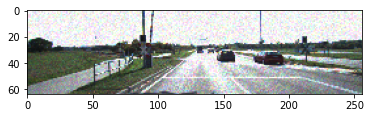

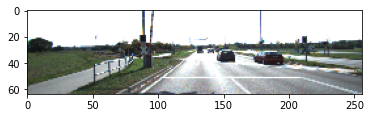

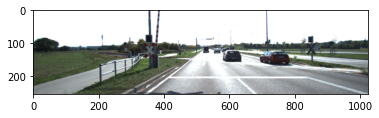

In [8]:
for image_lr, target_lr, target_hr in train_dataset.take(1):
    print(image_lr.shape)
    print(target_lr.shape)
    print(target_hr.shape)


    # casting to int for matplotlib to show the image
    plt.figure()
    plt.imshow(image_lr[0]*0.5 +0.5)
    plt.figure()
    plt.imshow(target_lr[0]*0.5 +0.5)
    plt.figure()
    plt.imshow(target_hr[0]*0.5 +0.5)
    break

## Build Model

### Blocks

In [9]:
def extract_first_features(filters, size, apply_batchnorm=True):
    ########### YOUR CODE HERE (OPTIONAL) ################
    """ ĐÂY LÀ ĐOẠN CODE OPTIONAL KHÔNG BẮT BUỘC PHẢI THỰC HIỆN 
    THEO FORMAT, NẾU CÓ CÁCH KHÁC CÁC BẠN CÓ THỂ CODE THEO Ý MÌNH 
    Extract feature của input images CONV2D -> BN(bool) -> LeakyRelu
    padding = same, stride = 1
    Parameters
    ----------
    filters         : int
        số lượng filters
    size            : int
        size của filter
    apply_batchnorm : bool
        có sử dụng batchnorm hay không 
    Returns
    -------
    result: (tùy thuộc vd Sequential)
        block CONV2D -> BN(bool) -> LeakyRelu
    """
    result = tf.keras.Sequential()
    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    
    # Conv2D stride=1
    result.add(layers.Conv2D(filters=filters, kernel_size=size, kernel_initializer=initializer,
                             strides=1, padding='same', use_bias=False))
    # check apply_batchnorm nếu True thì dùng 
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    # leakyRelu 
    result.add(layers.LeakyReLU())
    
    return result
    ###########################################
    
    
def downsample(filters, size, apply_batchnorm=True):
    ########### YOUR CODE HERE (OPTIONAL) ################
    """ ĐÂY LÀ ĐOẠN CODE OPTIONAL KHÔNG BẮT BUỘC PHẢI THỰC HIỆN 
    THEO FORMAT, NẾU CÓ CÁCH KHÁC CÁC BẠN CÓ THỂ CODE THEO Ý MÌNH 
    downsample trong Unet CONV2D -> BN(bool) -> LeakyRelu
    Parameters
    ----------
    filters         : int
        số lượng filters
    size            : int
        size của filter
    apply_batchnorm : bool
        có sử dụng batchnorm hay không 
    Returns
    -------
    result: (tùy thuộc vd Sequential)
        block CONV2D -> BN(bool) -> LeakyRelu
    """
    result = tf.keras.Sequential()
    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    
    # Conv2D stride=2
    result.add(layers.Conv2D(filters=filters, kernel_size=size, kernel_initializer=initializer,
                             strides=2, padding='same', use_bias=False))
    # check apply_batchnorm nếu True thì dùng 
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    
    # leakyRelu 
    result.add(layers.LeakyReLU())
    
    return result
    ###########################################
    


def downsample_dis(filters, size_12, size_3, apply_batchnorm=True):
    ########### YOUR CODE HERE (OPTIONAL) ################
    """ ĐÂY LÀ ĐOẠN CODE OPTIONAL KHÔNG BẮT BUỘC PHẢI THỰC HIỆN 
    THEO FORMAT, NẾU CÓ CÁCH KHÁC CÁC BẠN CÓ THỂ CODE THEO Ý MÌNH 
    downsample dành cho discriminator trong Unet CONV2D -> CONV2D -> CONV2D -> BN(bool) -> LeakyRelu
    Parameters
    ----------
    filters         : int
        số lượng filters
    size_12         : int
        kernel size cho CONV2D 1 và 2
    size_3          : int
        kernel size cho CONV2D 3
    apply_batchnorm : bool
        có sử dụng batchnorm hay không 
    Returns
    -------
    result: (tùy thuộc vd Sequential)
        CONV2D -> CONV2D -> CONV2D -> BN(bool) -> LeakyRelu
    """
    result = tf.keras.Sequential()
    initializer1 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    initializer2 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    initializer3 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    
    # Conv2D stride=1 kernel_size=size_12
    result.add(layers.Conv2D(filters=filters, kernel_size=size_12, kernel_initializer=initializer1,
                             strides=1, padding='same', use_bias=False))
    
    # Conv2D stride=1 kernel_size=size_12
    result.add(layers.Conv2D(filters=filters, kernel_size=size_12, kernel_initializer=initializer2,
                             strides=1, padding='same', use_bias=False))
    # Conv2D stride=2 kernel_size=size_3
    result.add(layers.Conv2D(filters=filters, kernel_size=size_23, kernel_initializer=initializer3,
                             strides=2, padding='same', use_bias=False))
    
    # check apply_batchnorm nếu True thì dùng 
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    
    # leakyRelu 
    result.add(layers.LeakyReLU())
    
    return result
    ###########################################
    

def upsample(filters, size, apply_dropout=False):
    ########### YOUR CODE HERE (OPTIONAL) ################
    """ ĐÂY LÀ ĐOẠN CODE OPTIONAL KHÔNG BẮT BUỘC PHẢI THỰC HIỆN 
    THEO FORMAT, NẾU CÓ CÁCH KHÁC CÁC BẠN CÓ THỂ CODE THEO Ý MÌNH 
    upsample trong Unet Conv2DTranspose -> BN -> Dropout(bool) -> LeakyRelu
    Parameters
    ----------
    filters         : int
        path nơi chứa ảnh data (4 ảnh nhỏ để split)
    size            : int
        kernel size
    apply_dropout : bool
        có sử dụng Dropout hay không 
    Returns
    -------
    result: (tùy thuộc vd Sequential)
        Conv2DTranspose -> BN -> Dropout(bool) -> LeakyRelu
    """
    result = tf.keras.Sequential()
    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    # Conv2DTranspose stride=2
    result.add(layers.Conv2DTranspose(filters=filters, kernel_size=size, kernel_initializer=initializer,
                             strides=2, padding='same', use_bias=False))
    
    # BatchNorm
    result.add(layers.BatchNormalization())
    
    # check apply_dropout nếu True thì dùng 
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    # Relu 
    result.add(layers.ReLU())
    
    return result
    ###########################################

def downsample_sr(filters, size, apply_batchnorm=True):
    ########### YOUR CODE HERE (OPTIONAL) ################
    """ ĐÂY LÀ ĐOẠN CODE OPTIONAL KHÔNG BẮT BUỘC PHẢI THỰC HIỆN 
    THEO FORMAT, NẾU CÓ CÁCH KHÁC CÁC BẠN CÓ THỂ CODE THEO Ý MÌNH 
    downsample cho super resolution Conv2D -> BN(bool) -> LeakyRelu 
    padding = same, stride = 1
    Parameters
    ----------
    filters         : int
        path nơi chứa ảnh data (4 ảnh nhỏ để split)
    size            : int
        kernel size
    apply_batchnorm : bool
        có sử dụng Dropout hay không 
    Returns
    -------
    result: (tùy thuộc vd Sequential)
        Conv2D -> BN -> Dropout(bool) -> LeakyRelu
    """
    result = tf.keras.Sequential()
    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    # Conv2D stride=1
    result.add(layers.Conv2D(filters=filters, kernel_size=size, kernel_initializer=initializer,
                             strides=1, padding='same', use_bias=False))
    
    # check apply_batchnorm nếu True thì dùng 
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    
    # leakyRelu 
    result.add(layers.LeakyReLU())
    return result
    ###########################################

def upsample_sr(filters, size, apply_dropout=False):
    ########### YOUR CODE HERE (OPTIONAL) ################
    """ ĐÂY LÀ ĐOẠN CODE OPTIONAL KHÔNG BẮT BUỘC PHẢI THỰC HIỆN 
    THEO FORMAT, NẾU CÓ CÁCH KHÁC CÁC BẠN CÓ THỂ CODE THEO Ý MÌNH 
    upsample trong super resolution Conv2DTranspose -> BN -> Dropout(bool) -> LeakyRelu
    Parameters
    ----------
    filters         : int
        path nơi chứa ảnh data (4 ảnh nhỏ để split)
    size            : int
        kernel size
    apply_dropout : bool
        có sử dụng Dropout hay không 
    Returns
    -------
    result: (tùy thuộc vd Sequential)
        Conv2DTranspose -> BN -> Dropout(bool) -> LeakyRelu
    """
    result = tf.keras.Sequential()
    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)

    # Conv2DTranspose stride=2
    result.add(layers.Conv2DTranspose(filters=filters, kernel_size=size, kernel_initializer=initializer,
                             strides=2, padding='same', use_bias=False))
    
    # BatchNorm
    result.add(layers.BatchNormalization())
    
    # check apply_dropout nếu True thì dùng 
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    # leakyRelu 
    result.add(layers.LeakyReLU())
    
    return result
    ###########################################

### Generator

In [10]:
def UNet_process(x):
    ########### YOUR CODE HERE (OPTIONAL) ################
    """ ĐÂY LÀ ĐOẠN CODE OPTIONAL KHÔNG BẮT BUỘC PHẢI THỰC HIỆN 
    THEO FORMAT, NẾU CÓ CÁCH KHÁC CÁC BẠN CÓ THỂ CODE THEO Ý MÌNH 
    Thực hiện theo kiến trúc Unet như Generator trong hình yêu cầu 
    để loại nhiễu khỏi ảnh (Code tương tự như link hướng dẫn của tensorflow)
    Parameters
    ----------
    x         : tensor 
        feature ảnh input
    Returns
    -------
    x: tensor
        ảnh xóa nhiễu
    """
    # (Code tương tự như link hướng dẫn của tensorflow)
    
    # tạo down_stack (encoder) gồm các downsample
    # mỗi step sẽ giảm size đi 2 lần 
    # số lượng filters mỗi step [64,256,512,512,512] qua 5 lần size sẽ giảm là 32 lần
    # kernel_size=4
    down_stack = [
        downsample(filters=64, size=4, apply_batchnorm=False),
        downsample(filters=256, size=4, apply_batchnorm=True),
        downsample(filters=512, size=4, apply_batchnorm=True),
        downsample(filters=512, size=4, apply_batchnorm=True),
        downsample(filters=512, size=4, apply_batchnorm=True),
    ]

    # tạo up_stack (decoder) gồm các upsample
    # mỗi step sẽ giảm size tăng lên 2 lần và số lượng filters tăng 2
    # số lượng filters mỗi step  [512,512,256,64] qua 5 lần size sẽ giảm là 32 lần
    # kernel_size=4
    up_stack = [
        upsample(filters=512, size=4, apply_dropout=True),
        upsample(filters=512, size=4, apply_dropout=True),
        upsample(filters=256, size=4, apply_dropout=True),
        upsample(filters=64, size=4, apply_dropout=False),
    ]

    # tạo last layer nhân 2 lần kích thước feature với Conv2DTranspose(), channel=3 cho output ảnh 
    # đã xóa nhiễu (chọn activation phù hợp)
    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    last = layers.Conv2DTranspose(filters=3, kernel_size=4, kernel_initializer=initializer,
                             strides=2, padding='same', activation='tanh')
                
    
    # Downsampling through the model (Code tương tự như link hướng dẫn của tensorflow)
    # thực vòng lập để chạy x cho mỗi layer trong down_stack
    # đồng thời đưa kết quả mỗi layer vào list (để dùng cho skip connection)
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    # reverse skip connection list loại bỏ layer cuối (bridge không dùng skip connection)
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections (Code tương tự như link hướng dẫn của tensorflow)
    # upsamling và concatenate với level tương ứng (element trong list skip connection)
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    # đi vào layer last đã tạo ở trên để ra ảnh có kích thước bằng ảnh input và đã xóa nhiễu
    x = last(x)
    
    return x
    ###########################################
        
    
def Generator(): 
    ########### YOUR CODE HERE (OPTIONAL) ################
    """ ĐÂY LÀ ĐOẠN CODE OPTIONAL KHÔNG BẮT BUỘC PHẢI THỰC HIỆN 
    THEO FORMAT, NẾU CÓ CÁCH KHÁC CÁC BẠN CÓ THỂ CODE THEO Ý MÌNH 
    Thực hiện toàn bộ task của model tạo ảnh xóa nhiễu sau đó tạo ảnh 
    supre resolution (x4 size)
    
    -------
    model: tf.keras.models.Model
        model tạo ảnh xóa nhiễu và ảnh super resolution 
    """

    # tạo layer input với shape = input low resolution image (có nhiễu)
    inputs = layers.Input(shape=(LOW_HEIGHT, LOW_WIDTH, 3))
    
    # extract_first_features, filters=16, kernel_size  = 3
    # Các bạn có thể lựa chọn thêm các thành phần khác để cải thiện model 
    x = extract_first_features(filters=64, size=3, apply_batchnorm=True)(inputs)

    # Đi vào UNet_process để denoise thu được fake_lr
    x = UNet_process(x)
    fake_lr = x

    # rẻ nhánh và đi tiếp vào extract_first_features filters = 64, kernel_size = 3
    x = extract_first_features(filters=64, size=3, apply_batchnorm=True)(x)

    # thực hiện downsample_sr filters = 256, kernel_size = 3
    x = downsample_sr(filters=256, size=3, apply_batchnorm=True)(x)
    
    # thực hiện downsample_sr filters = 256, kernel_size = 3
    x = downsample_sr(filters=256, size=3, apply_batchnorm=True)(x)
    
    # thực hiện upsample_sr filters = 128, kernel_size = 4
    x = upsample_sr(filters=128, size=4, apply_dropout=False)(x)
    
    # thực hiện downsample_sr filters = 128, kernel_size = 3
    x = downsample_sr(filters=128, size=3, apply_batchnorm=True)(x)
    
    # tạo layer last Conv2DTranspose filters = 6, kernel_size = 4, strides=2  (tạo ảnh high resolution) 
    # qua layer last để lấy fake_hr (chọn activation phù hợp)
    initializer =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    last = layers.Conv2DTranspose(filters=3, kernel_size=4, kernel_initializer=initializer,
                             strides=2, padding='same', activation='tanh')
    
    fake_hr = last(x)
    
    # tạo model là inputs=input layer ở trên và outputs=[fake_lr, fake_hr]
    model = models.Model(inputs=inputs, outputs=[fake_lr, fake_hr])
    
    return model
    ###########################################

In [11]:
generator = Generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 256, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 sequential (Sequential)        (None, 64, 256, 64)  1984        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32, 128, 64)  65536       ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 16, 64, 256)  263168      ['sequential_1[0][0]']       

### Discriminator

In [12]:
def Discriminator1():
    ########### YOUR CODE HERE (OPTIONAL) ################
    """ ĐÂY LÀ ĐOẠN CODE OPTIONAL KHÔNG BẮT BUỘC PHẢI THỰC HIỆN 
    THEO FORMAT, NẾU CÓ CÁCH KHÁC CÁC BẠN CÓ THỂ CODE THEO Ý MÌNH 
    Discrminator 1 dùng cho phân biệt ảnh low resolution 
    
    -------
    model: tf.keras.models.Model
        model phân loại ảnh sau khi xóa nhiễu của model và ảnh targe_lr có giống nhau hay không 
        generator có đánh lừa được discriminator
    """
    # các bạn tham khảo link sau 
    # https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_discriminator
    # phần này khá đơn giản nó hoạt động giống như 1 mạng classification bình thường đã được học 
    # các bạn có thể tùy ý thêm ý tưởng ở đây.
    inp = tf.keras.layers.Input(shape=[LOW_HEIGHT, LOW_WIDTH, 3])
    tar = tf.keras.layers.Input(shape=[LOW_HEIGHT, LOW_WIDTH, 3])
    x = tf.keras.layers.concatenate([inp, tar])
    
    x = downsample(filters=64,  size=4, apply_batchnorm=False)(x)
    x = downsample(filters=128, size=4, apply_batchnorm=True)(x)
    x = downsample(filters=256, size=4, apply_batchnorm=True)(x)
    
    initializer1 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    initializer2 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    
    x = layers.Conv2D(filters=256, kernel_size=3, kernel_initializer=initializer1,
                             strides=1, use_bias=False)(x)
    x = layers.Conv2D(filters=1, kernel_size=3, kernel_initializer=initializer2,
                             strides=1, use_bias=False)(x)
    
    model = models.Model(inputs=[inp,tar], outputs=x)
    
    return model
    #########################################################
    
def Discriminator2():
    ########### YOUR CODE HERE (OPTIONAL) ################
    """ ĐÂY LÀ ĐOẠN CODE OPTIONAL KHÔNG BẮT BUỘC PHẢI THỰC HIỆN 
    THEO FORMAT, NẾU CÓ CÁCH KHÁC CÁC BẠN CÓ THỂ CODE THEO Ý MÌNH 
    Discrminator 2 dùng cho phân biệt ảnh high resolution 
    
    -------
    model: tf.keras.models.Model
        model phân loại ảnh sau khi model thực hiện tạo ra ảnh super resolution và ảnh targe_lr có giống nhau hay không 
        generator có đánh lừa được discriminator2
    """
    # các bạn tham khảo link sau 
    # https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_discriminator
    # phần này khá đơn giản nó hoạt động giống như 1 mạng classification bình thường đã được học 
    # các bạn có thể tùy ý thêm ý tưởng ở đây.
    inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    x = downsample(filters=64,  size=4, apply_batchnorm=False)(inp)
    x = downsample(filters=128, size=4, apply_batchnorm=True)(x)
    x = downsample(filters=256, size=4, apply_batchnorm=True)(x)
    
    initializer1 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    initializer2 =  tf.keras.initializers.RandomNormal(mean=0. , stddev=0.02)
    
    x = layers.Conv2D(filters=256, kernel_size=3, kernel_initializer=initializer1,
                             strides=1, use_bias=False)(x)
    x = layers.Conv2D(filters=1, kernel_size=3, kernel_initializer=initializer2,
                             strides=1, use_bias=False)(x)
    
    model = models.Model(inputs=inp, outputs=x)
    return model
    #########################################################

In [13]:
discriminator1 = Discriminator1()
discriminator2 = Discriminator2()

In [14]:
discriminator1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 256, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 256, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 concatenate_4 (Concatenate)    (None, 64, 256, 6)   0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [15]:
discriminator2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 1024, 3)]    0         
                                                                 
 sequential_18 (Sequential)  (None, 128, 512, 64)      3072      
                                                                 
 sequential_19 (Sequential)  (None, 64, 256, 128)      131584    
                                                                 
 sequential_20 (Sequential)  (None, 32, 128, 256)      525312    
                                                                 
 conv2d_18 (Conv2D)          (None, 30, 126, 256)      589824    
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 124, 1)        2304      
                                                                 
Total params: 1,252,096
Trainable params: 1,251,328
Non-tra

In [16]:
img1 = tf.random.normal((1, IMG_HEIGHT//4, IMG_WIDTH//4, 3))
img2 = tf.random.normal((1, IMG_HEIGHT, IMG_WIDTH, 3))

output1_d = discriminator1([img1,img1])
print(output1_d.shape)

output2_d = discriminator2(img2)
print(output2_d.shape)

2022-03-30 22:14:06.762244: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


(1, 4, 28, 1)
(1, 28, 124, 1)


## Compile & Train

### Loss

#### Discriminator Loss

In [17]:
# Khai báo BCE loss
loss_dsic_object = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.03)
def discriminator_loss(disc_real_output, disc_generated_output):
    ########### YOUR CODE HERE (OPTIONAL) ################
    """ ĐÂY LÀ ĐOẠN CODE OPTIONAL KHÔNG BẮT BUỘC PHẢI THỰC HIỆN 
    THEO FORMAT, NẾU CÓ CÁCH KHÁC CÁC BẠN CÓ THỂ CODE THEO Ý MÌNH 
    tính loss cho Discrminator  
    Parameters
    ----------
    disc_real_output         : tf.float32 (tensor)
        Kết quả khi target đi qua discriminator 
    disc_generated_output    : tf.float32 (tensor)
        Kết quả khi fake image  đi qua discriminator 
    -------
    total_loss: tf.float32
        loss tổng của discriminator
    """
    # dùng loss_dsic_object tính loss disc_real_output với ma trận ones cùng size disc_real_output
    real_los = loss_dsic_object(tf.ones_like(disc_real_output), disc_real_output)
    
    # dùng loss_dsic_object tính loss disc_generated_output với ma trận zeros cùng size disc_generated_output
    fake_los = loss_dsic_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    # total_loss = tổng 2 loss trên
    total_loss = real_los + fake_los
    
    return total_loss
    #########################################################


#### Generator Loss

In [18]:
# các bạn chọn weight cho loss
LAMBDA = 40
################################

loss_gener1_object  = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_gener2_object  = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def generator_loss1(disc_generated_output, gen_output, target):
    ########### YOUR CODE HERE (OPTIONAL) ################
    """ ĐÂY LÀ ĐOẠN CODE OPTIONAL KHÔNG BẮT BUỘC PHẢI THỰC HIỆN 
    THEO FORMAT, NẾU CÓ CÁCH KHÁC CÁC BẠN CÓ THỂ CODE THEO Ý MÌNH 
    tính loss cho generator cho phần denoise
    Parameters
    ----------
    disc_generated_output         : tf.float32 (tensor)
        Kết quả khi ảnh low resolution (xóa nhiễu) đi qua discriminator 
    gen_output    : tf.float32 (tensor)
        Kết quả ảnh low resolution được tạo ra 
    target        : tf.float32 
        Ảnh targe low resolution
    -------
    total_loss: tf.float32
        loss tổng của generator phần denoise
    gan_loss: tf.float32
        loss gan phần denoise
    l1_loss: tf.float32
        l1 loss generator phần denoise 
    """
    # dùng loss_gener1_object tính gan_loss 
    # bằng cách tính loss disc_generated_output với ma trận ones cùng size disc_generated_output
    gan_loss = loss_gener1_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # dùng L1 loss tính l1_loss giữa gen_output và target
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    # total_loss = tổng 2 loss trên với weight tùy theo các bạn chọn 
    total_loss = gan_loss + LAMBDA*l1_loss

    return total_loss, gan_loss, l1_loss
    #########################################################



def generator_loss2(disc_generated_output, gen_output, target):
    ########### YOUR CODE HERE (OPTIONAL) ################
    """ ĐÂY LÀ ĐOẠN CODE OPTIONAL KHÔNG BẮT BUỘC PHẢI THỰC HIỆN 
    THEO FORMAT, NẾU CÓ CÁCH KHÁC CÁC BẠN CÓ THỂ CODE THEO Ý MÌNH 
    tính loss cho generator cho phần super resolution 
    Parameters
    ----------
    disc_generated_output         : tf.float32 (tensor)
        Kết quả khi ảnh high resolution được tạo từ model  đi qua discriminator 
    gen_output    : tf.float32 (tensor)
        Kết quả ảnh high resolution được tạo ra 
    target        : tf.float32 
        Ảnh targe high resolution
    -------
    total_loss: tf.float32
        loss tổng của generator phần super resolution 
    gan_loss: tf.float32
        loss gan phần super resolution 
    l1_loss: tf.float32
        l1 loss generator phần super resolution 
    """
    # dùng loss_gener1_object tính gan_loss 
    # bằng cách tính loss disc_generated_output với ma trận ones cùng size disc_generated_output
    gan_loss = loss_gener1_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # dùng L1 loss tính l1_loss giữa gen_output và target
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    # total_loss = tổng 2 loss trên với weight tùy theo các bạn chọn 
    total_loss = gan_loss + LAMBDA*l1_loss
    
    return total_loss, gan_loss, l1_loss
    #########################################################




#### Optimizers

In [19]:
# các bạn tùy chọn đây là mẫu
generator_optimizer     = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator1_optimizer = tf.keras.optimizers.Adam(7e-3, beta_1=0.5)
discriminator2_optimizer = tf.keras.optimizers.Adam(7e-3, beta_1=0.5)

#### Config Checkpoint

In [20]:
checkpoint_dir = 'checkpoints1'
# chọn đường dẫn lưu checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator1_optimizer=discriminator1_optimizer,
                                 discriminator2_optimizer=discriminator2_optimizer,
                                 generator=generator,
                                 discriminator1=discriminator1,
                                 discriminator2=discriminator2)

#### Evaluation and Show Result Functions

In [34]:
# phần này các bạn nên chỉnh sửa cho phù hợp với model output của mình
def evaluate(model, epoch):        
    psnr_mean = 0.0
    for image_lr, target_lr, target_hr in test_dataset:
        fake_lr, fake_hr = model(image_lr, training=False)
        psnr_b = tf.image.psnr(fake_hr, target_hr, max_val=1.0)
        psnr_mean = tf.math.reduce_mean(psnr_b)
    
#     psnr_mean = psnr_mean/10.0
    print('-------- psnr: ', psnr_mean.numpy(), '   ----- epoch: ', epoch)
    return psnr_mean
    

def generate_images(model, image_lr, target_sr, is_fake_lr=False):
    fake_lr, fake_hr = model([image_lr], training=False)
    if is_fake_lr:
        display_list = [image_lr[0], fake_lr[0], target_sr[0], fake_hr[0]]
        title_l = ['Input', 'Denoise', 'Real', 'Generated']    
        plt.figure(figsize=(25,30))
        for i in range(4):
            plt.subplot(1, 4, i+1)
            plt.title(title_l[i])
            plt.imshow(display_list[i] * 0.5 + 0.5)
    else:
        display_list = [image_lr[0], target_sr[0], fake_hr[0]]
        title_l = ['Input', 'Real', 'Generated']    
        plt.figure(figsize=(25,30))
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title_l[i])
            plt.imshow(display_list[i] * 0.5 + 0.5)
#         plt.axis('off')
    plt.show()

#### Train Function

In [22]:
@tf.function
def train_step(image_lr, target_lr, target_hr):
    ########### YOUR CODE HERE (OPTIONAL) ################
    """ ĐÂY LÀ ĐOẠN CODE OPTIONAL KHÔNG BẮT BUỘC PHẢI THỰC HIỆN 
    THEO FORMAT, NẾU CÓ CÁCH KHÁC CÁC BẠN CÓ THỂ CODE THEO Ý MÌNH 
    tính loss cho generator cho phần super resolution 
    Parameters
    ----------
    image_lr         : tf.float32 
        Ảnh low resolution và nhiễu
    target_lr        : tf.float32 
        target low resolution 
    target_hr        : tf.float32 
        Ảnh targe high resolution
    -------
    gan_loss: tf.float32
        loss tổng của generator loss
    l1_loss: tf.float32
        loss gan phần super resolution
    disc_loss: tổng discriminator loss 
    
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc1_tape, tf.GradientTape() as disc2_tape:
        # lấy kêt quả từ generator (fake_lr, fake_hr) generator(image_lr)
        fake_lr, fake_hr = generator(image_lr, training=True)
        
        # lấy disc_lr_real_output, disc_lr_generated_output từ discriminator1
        disc_lr_real_output = discriminator1([image_lr,target_lr], training=True)
        disc_lr_generated_output = discriminator1([image_lr, fake_lr], training=True)
        
        # lấy disc_hr_real_output, disc_hr_generated_output từ discriminator2
        disc_hr_real_output = discriminator2(target_hr, training=True)
        disc_hr_generated_output = discriminator2(fake_hr, training=True)
        
        # lấy total_lr_loss, gan_lr_loss, l1_lr_loss từ generator_loss1(disc_lr_generated_output, fake_lr, target_lr)
        total_lr_loss, gan_lr_loss, l1_lr_loss = generator_loss1(disc_lr_generated_output, fake_lr, target_lr)
        
        # lấy total_hr_loss, gan_hr_loss, l1_hr_loss từ generator_loss2(disc_hr_generated_output, fake_hr, target_hr)
        total_hr_loss, gan_hr_loss, l1_hr_loss = generator_loss2(disc_hr_generated_output, fake_hr, target_hr)
        
        # lấy disc_lr_loss, discriminator_loss(disc_lr_real_output, disc_lr_generated_output)
        disc_lr_loss = discriminator_loss(disc_lr_real_output, disc_lr_generated_output)
        
        # lấy disc_hr_loss, discriminator_loss(disc_hr_real_output, disc_hr_generated_output)
        disc_hr_loss = discriminator_loss(disc_hr_real_output, disc_hr_generated_output)
        
        # tính gan_loss, l1_loss, disc_loss là tổng các loss liên quan 
        # vd gan_loss = gan_lr_loss + gan_hr_loss
        gan_loss = gan_lr_loss + gan_hr_loss
        l1_loss = l1_lr_loss + l1_hr_loss
        disc_loss = disc_lr_loss + disc_hr_loss
        
        total_gen_loss = total_lr_loss + total_hr_loss
    # tính gradient cho các model tương ứng generator-gen_tape
    # disc1_tape-discriminator1, disc2_tape-discriminator2
    gen_gradients = gen_tape.gradient(total_gen_loss, generator.trainable_variables)
    disc1_gradients = disc1_tape.gradient(disc_lr_loss, discriminator1.trainable_variables)
    disc2_gradients = disc2_tape.gradient(disc_hr_loss, discriminator2.trainable_variables)
    
    # apply graident cho các model tương tự như trên 
    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator1_optimizer.apply_gradients(zip(disc1_gradients, discriminator1.trainable_variables))
    discriminator2_optimizer.apply_gradients(zip(disc2_gradients, discriminator2.trainable_variables))
    
    return gan_loss, l1_loss, disc_loss
    #########################################################
    

    

    
    
def fit(train_ds, epochs, test_ds):
    best_psnr = 0.0
    for epoch in range(epochs):
        start = time.time()        

        # Train
        for image_lr, target_lr, target_hr in train_ds:            
#             
            gan_loss, l1_loss, disc_loss = train_step(image_lr, target_lr, target_hr)
        
        psnr = evaluate(generator, epoch)        
        if best_psnr < psnr:
            checkpoint.save(file_prefix = checkpoint_prefix)
            best_psnr = psnr
            
            for image_lr, target_lr, target_hr in test_ds.take(1):
                generate_images(generator, image_lr, target_hr)

        
        print('epoch {}  gan_loss: {}  l1_loss: {}  disc_loss: {}'.format(epoch, gan_loss, l1_loss, disc_loss))


#### Train

-------- psnr:  5.722911


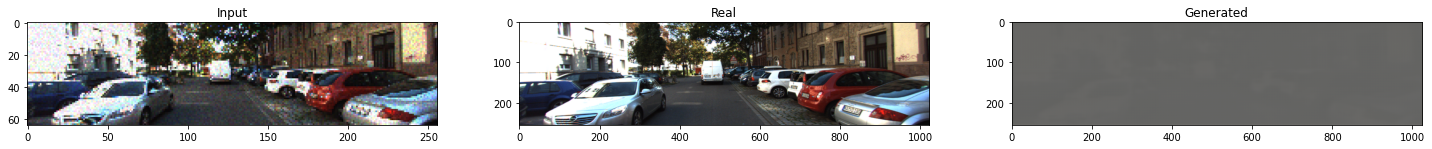

epoch 0  gan_loss: 175.92881774902344  l1_loss: 0.36849772930145264  disc_loss: 266.9622802734375
-------- psnr:  6.24217


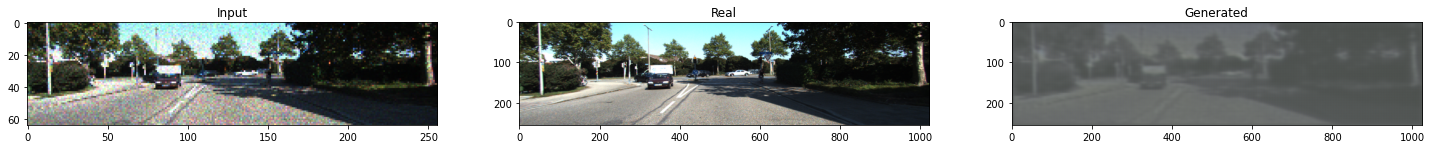

epoch 1  gan_loss: 1.414139986038208  l1_loss: 0.33512404561042786  disc_loss: 2.746514320373535
-------- psnr:  10.630623


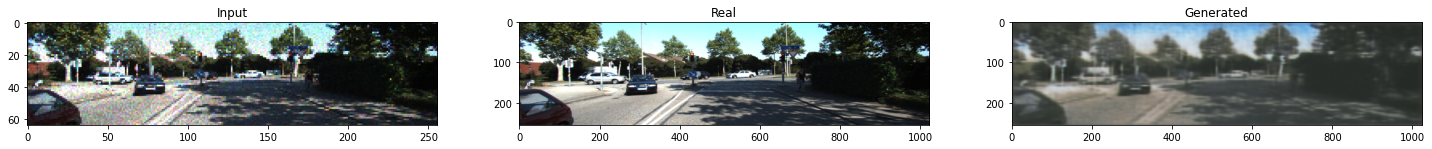

epoch 2  gan_loss: 1.2927474975585938  l1_loss: 0.221655011177063  disc_loss: 2.7839136123657227
-------- psnr:  15.7729845


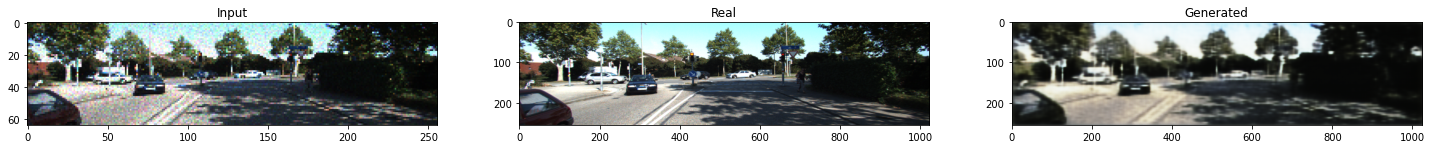

epoch 3  gan_loss: 1.3964673280715942  l1_loss: 0.18686163425445557  disc_loss: 2.775254249572754
-------- psnr:  14.264364
epoch 4  gan_loss: 1.4432153701782227  l1_loss: 0.28287824988365173  disc_loss: 2.8133387565612793
-------- psnr:  14.464657
epoch 5  gan_loss: 1.4255132675170898  l1_loss: 0.19149887561798096  disc_loss: 2.7730793952941895
-------- psnr:  13.778548
epoch 6  gan_loss: 1.4432282447814941  l1_loss: 0.17101868987083435  disc_loss: 2.7930262088775635
-------- psnr:  15.586753
epoch 7  gan_loss: 1.4353482723236084  l1_loss: 0.15670156478881836  disc_loss: 2.775923490524292
-------- psnr:  15.743779
epoch 8  gan_loss: 1.4584884643554688  l1_loss: 0.24392905831336975  disc_loss: 2.7979846000671387
-------- psnr:  13.982504
epoch 9  gan_loss: 1.3616735935211182  l1_loss: 0.20069512724876404  disc_loss: 2.772784471511841
-------- psnr:  8.170816
epoch 10  gan_loss: 1.3987897634506226  l1_loss: 0.36227017641067505  disc_loss: 2.7839460372924805
-------- psnr:  15.402901
epo

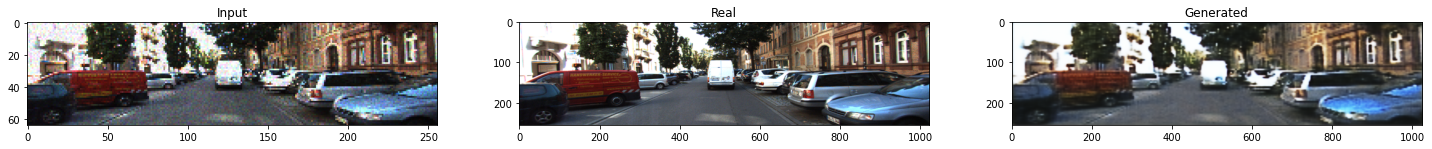

epoch 19  gan_loss: 1.3840863704681396  l1_loss: 0.21250519156455994  disc_loss: 2.766400098800659
-------- psnr:  13.311053
epoch 20  gan_loss: 1.4679498672485352  l1_loss: 0.19423067569732666  disc_loss: 2.7742953300476074
-------- psnr:  14.914887
epoch 21  gan_loss: 1.405545711517334  l1_loss: 0.17787930369377136  disc_loss: 2.772752523422241
-------- psnr:  16.102741
epoch 22  gan_loss: 1.488152265548706  l1_loss: 0.1704528033733368  disc_loss: 2.8490114212036133
-------- psnr:  16.30218


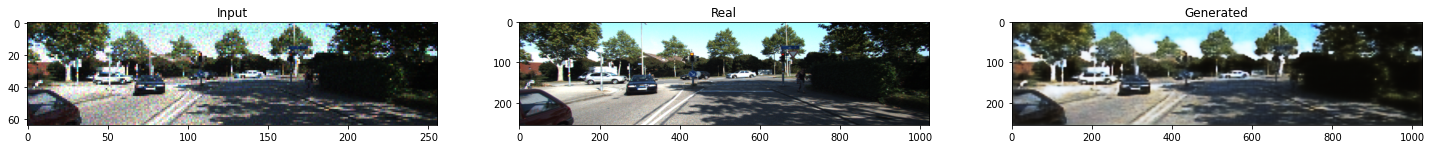

epoch 23  gan_loss: 1.3848977088928223  l1_loss: 0.19858849048614502  disc_loss: 2.7718148231506348
-------- psnr:  14.001063
epoch 24  gan_loss: 1.445701003074646  l1_loss: 0.25052976608276367  disc_loss: 2.817753553390503
-------- psnr:  12.911782
epoch 25  gan_loss: 1.3226091861724854  l1_loss: 0.2331935167312622  disc_loss: 2.768282890319824
-------- psnr:  15.148284
epoch 26  gan_loss: 1.382568359375  l1_loss: 0.18377342820167542  disc_loss: 2.779625415802002
-------- psnr:  14.684636
epoch 27  gan_loss: 1.4291539192199707  l1_loss: 0.1943221092224121  disc_loss: 2.7593212127685547
-------- psnr:  15.12776
epoch 28  gan_loss: 1.3884494304656982  l1_loss: 0.1719387173652649  disc_loss: 2.768061399459839
-------- psnr:  16.587963


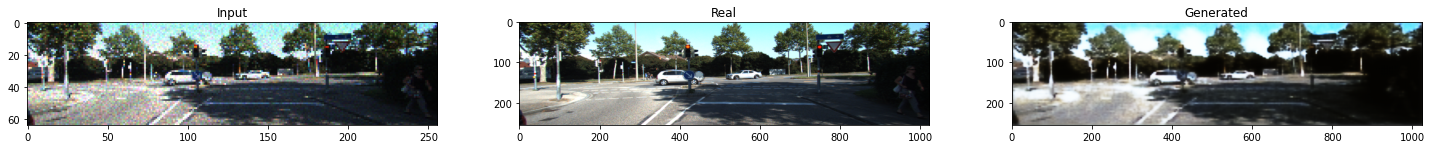

epoch 29  gan_loss: 1.1258882284164429  l1_loss: 0.5569130182266235  disc_loss: 2.844910144805908
-------- psnr:  14.286417
epoch 30  gan_loss: 1.4386765956878662  l1_loss: 0.21367700397968292  disc_loss: 2.7786550521850586
-------- psnr:  16.207222
epoch 31  gan_loss: 1.4542039632797241  l1_loss: 0.14990031719207764  disc_loss: 2.7743372917175293
-------- psnr:  14.7818775
epoch 32  gan_loss: 1.7400879859924316  l1_loss: 0.21006479859352112  disc_loss: 2.8295133113861084
-------- psnr:  15.105148
epoch 33  gan_loss: 1.3529558181762695  l1_loss: 0.1954817771911621  disc_loss: 2.77933406829834
-------- psnr:  17.351545


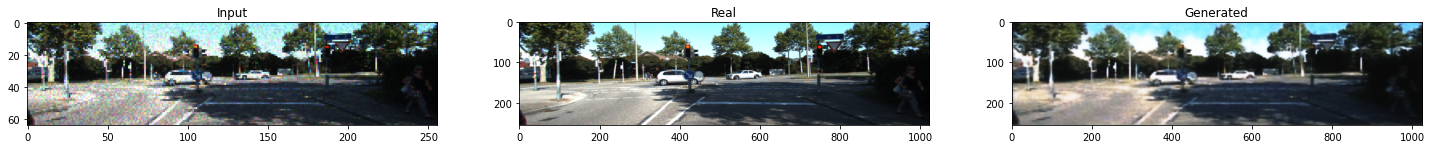

epoch 34  gan_loss: 1.364550232887268  l1_loss: 0.16521255671977997  disc_loss: 2.7841718196868896
-------- psnr:  14.855293
epoch 35  gan_loss: 1.4328274726867676  l1_loss: 0.16798628866672516  disc_loss: 2.762577533721924
-------- psnr:  16.637318
epoch 36  gan_loss: 1.4144644737243652  l1_loss: 0.14213615655899048  disc_loss: 2.7481980323791504
-------- psnr:  15.286015
epoch 37  gan_loss: 1.3019657135009766  l1_loss: 0.23985549807548523  disc_loss: 2.783738136291504
-------- psnr:  14.315575
epoch 38  gan_loss: 1.447513222694397  l1_loss: 0.3371126055717468  disc_loss: 2.8047361373901367
-------- psnr:  14.116015
epoch 39  gan_loss: 1.3982070684432983  l1_loss: 0.1831633746623993  disc_loss: 2.755331516265869
-------- psnr:  15.579581
epoch 40  gan_loss: 1.451338291168213  l1_loss: 0.1750035285949707  disc_loss: 2.770343780517578
-------- psnr:  14.806744
epoch 41  gan_loss: 1.2434427738189697  l1_loss: 0.19770465791225433  disc_loss: 2.790846347808838
-------- psnr:  24.532736


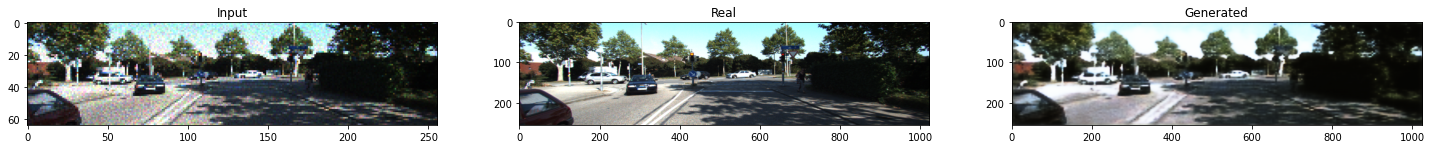

epoch 42  gan_loss: 1.3684170246124268  l1_loss: 0.9187480211257935  disc_loss: 2.5490667819976807
-------- psnr:  14.959098
epoch 43  gan_loss: 1.369663119316101  l1_loss: 0.1555107831954956  disc_loss: 2.7746124267578125
-------- psnr:  15.451239
epoch 44  gan_loss: 1.4337310791015625  l1_loss: 0.15230803191661835  disc_loss: 2.7815592288970947
-------- psnr:  16.442432
epoch 45  gan_loss: 1.4748544692993164  l1_loss: 0.12439043074846268  disc_loss: 2.795475959777832
-------- psnr:  15.482301
epoch 46  gan_loss: 1.338108777999878  l1_loss: 0.15958590805530548  disc_loss: 2.769648551940918
-------- psnr:  15.108696
epoch 47  gan_loss: 1.4277820587158203  l1_loss: 0.22480711340904236  disc_loss: 2.764984130859375
-------- psnr:  15.308441
epoch 48  gan_loss: 1.4881260395050049  l1_loss: 0.1483989953994751  disc_loss: 2.777452230453491
-------- psnr:  16.7426
epoch 49  gan_loss: 1.541823387145996  l1_loss: 0.18155598640441895  disc_loss: 2.7209761142730713
-------- psnr:  12.595475
epoc

In [23]:
        
EPOCHS = 151
fit(train_dataset, EPOCHS, test_dataset)

###  Show

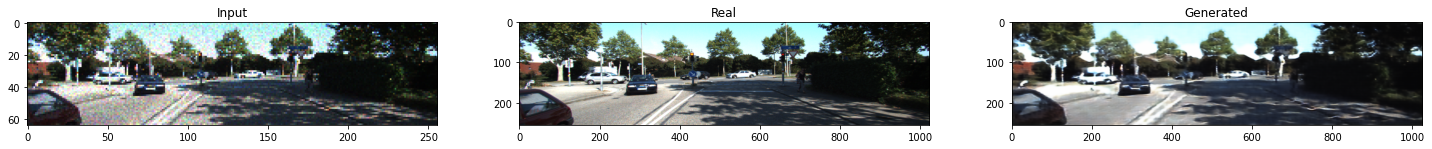

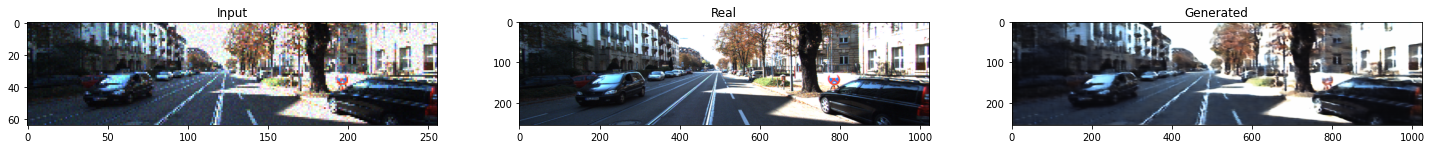

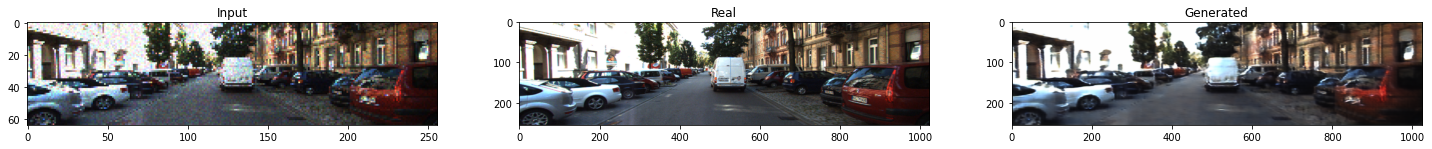

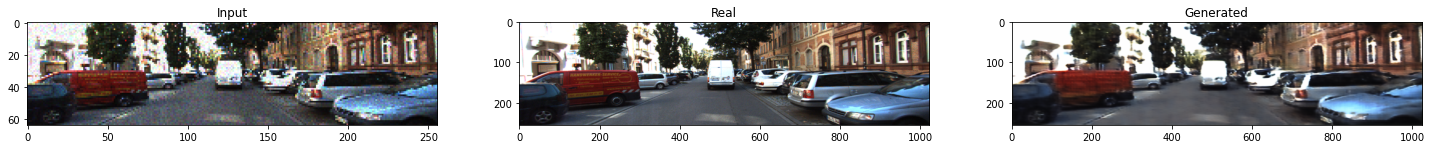

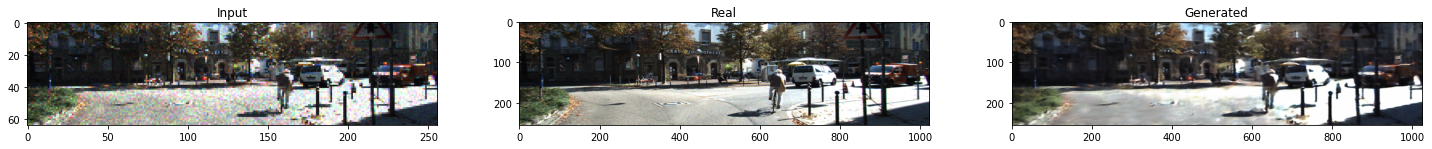

In [36]:
for image_lr, target_lr, target_hr in test_dataset.take(5):
    generate_images(generator, image_lr, target_hr, is_fake_lr=False)